In [2]:
import time
import os
import subprocess
import cv2
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Taking Photos with a Webcam

In [73]:
def take_photos(folder_name, delay_s=3):
    folder_path = f"../data/images/{folder_name}"
    os.makedirs(folder_path, exist_ok=True)

    print("\nTaking photo in...")
    while delay_s > 0:
        print(f"{delay_s}...")
        time.sleep(1)
        delay_s -= 1

    # Capture RAW image in PPM format (lossless)
    raw_image_path = f"{folder_path}/reference.ppm"
    command = f"fswebcam --no-banner {raw_image_path}"
    subprocess.run(command, shell=True)

    # Convert RAW image to different formats
    img = Image.open(raw_image_path)
    img.save(f"{folder_path}/output.bmp", format="BMP")
    img.save(f"{folder_path}/output.jpg", format="JPEG")
    img.save(f"{folder_path}/output.png", format="PNG")

In [74]:
take_photos("test_1")
take_photos("test_2")
take_photos("test_3")


Taking photo in...
3...
2...
1...


--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 352x288.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '../data/images/test_1/reference.ppm'.



Taking photo in...
3...
2...
1...


--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 352x288.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '../data/images/test_2/reference.ppm'.



Taking photo in...
3...
2...
1...


--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 352x288.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '../data/images/test_3/reference.ppm'.


# Getting image data into a DF

In [75]:
def get_df_info():
    base_path = "../data/images/"
    image_formats = ["bmp", "jpg", "png"]
    test_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    
    data = []

    for folder_name in test_folders:
        folder_path = os.path.join(base_path, folder_name)

        ref_img_path = os.path.join(folder_path, "reference.ppm")
        ref_img = cv2.imread(ref_img_path, cv2.IMREAD_GRAYSCALE)
        # if ref_img is None:
        #     print(f"Skipping {folder} (No valid reference image found)")
        #     continue
        
        for fmt in image_formats:
            file_path = os.path.join(folder_path, f"output.{fmt}")
            compare_img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if compare_img is not None:
                # Resize to match reference if needed
                compare_img = cv2.resize(compare_img, (ref_img.shape[1], ref_img.shape[0]))

                # Compute SSIM
                ssim_score = ssim(ref_img, compare_img)
                
                # Compute Mean Squared Error (MSE)
                mse_score = np.mean((ref_img.astype("float") - compare_img.astype("float")) ** 2)

            if os.path.exists(file_path):
                file_size = os.path.getsize(file_path) / 1024  # Convert to KB
                img = cv2.imread(file_path)
                if img is not None:
                    height, width = img.shape[:2]
                image_size = f"{width}x{height}"  # Known capture resolution
                data.append([folder_name, fmt.upper(), image_size, f"{file_size:.2f} KB", round(ssim_score, 4), round(mse_score, 4)])

    # Create a global DataFrame
    df = pd.DataFrame(data, columns=["Test Folder", "Format", "Resolution", "File Size", "SSIM", "MSE"])
    return df

In [76]:
df = get_df_info()
df.head(10)

,Test Folder,Format,Resolution,File Size,SSIM,MSE
0,test_2,BMP,352x288,297.05 KB,0.9996,0.0094
1,test_2,JPG,352x288,2.96 KB,0.9997,0.0046
2,test_2,PNG,352x288,12.62 KB,0.9930,0.2819
3,test_3,BMP,352x288,297.05 KB,0.9998,0.0074
4,test_3,JPG,352x288,2.97 KB,0.9999,0.0013
5,test_3,PNG,352x288,13.03 KB,0.9929,0.3652
6,test_1,BMP,352x288,297.05 KB,0.9997,0.0115
7,test_1,JPG,352x288,3.16 KB,0.9998,0.0047
8,test_1,PNG,352x288,15.34 KB,0.9934,0.3322


# Visualisation

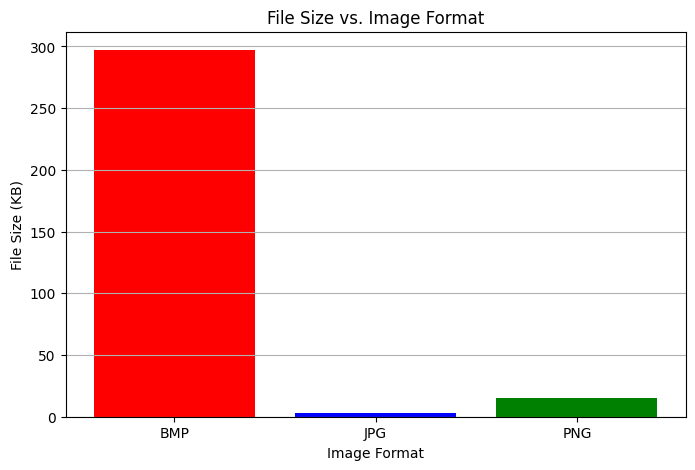

In [78]:
plt.figure(figsize=(8, 5))
plt.bar(df["Format"], df["File Size"].str.replace(" KB", "").astype(float), color=["red", "blue", "green"])
plt.xlabel("Image Format")
plt.ylabel("File Size (KB)")
plt.title("File Size vs. Image Format")
plt.grid(axis="y")
plt.show()

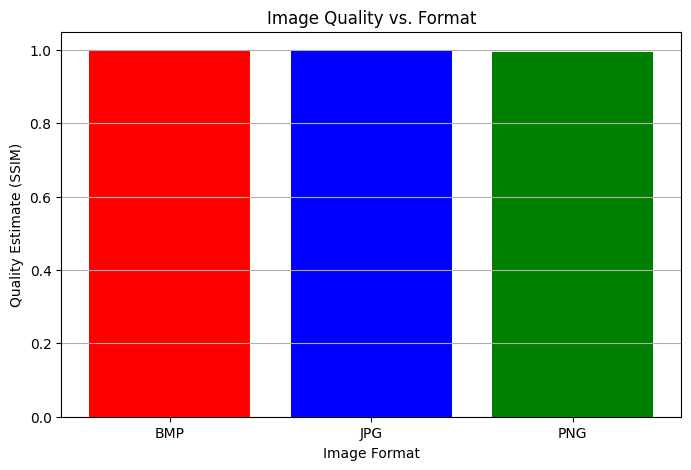

In [80]:
plt.figure(figsize=(8, 5))
plt.bar(df["Format"], df["SSIM"], color=["red", "blue", "green"])
plt.xlabel("Image Format")
plt.ylabel("Quality Estimate (SSIM)")
plt.title("Image Quality vs. Format")
plt.grid(axis="y")
plt.show()

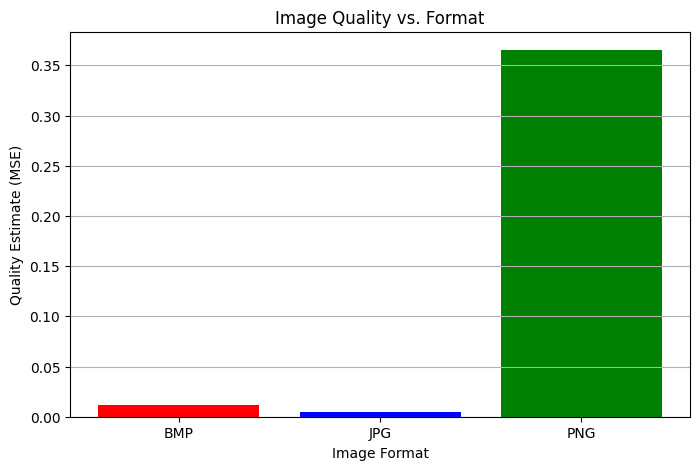

In [82]:
plt.figure(figsize=(8, 5))
plt.bar(df["Format"], df["MSE"], color=["red", "blue", "green"])
plt.xlabel("Image Format")
plt.ylabel("Quality Estimate (MSE)")
plt.title("Image Quality vs. Format")
plt.grid(axis="y")
plt.show()